In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns

In [3]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


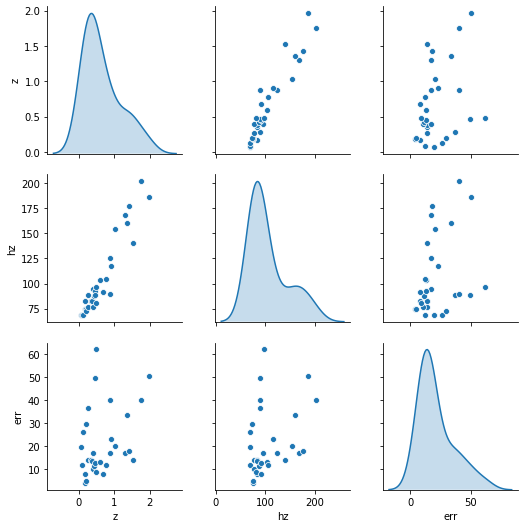

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [5]:
a = np.array([25,  3,  9,  7, 19,  2, 17, 16,  6, 28, 12, 20, 21, 26, 27, 11,  1,
       10, 30, 13, 29,  0,  8, 18, 24,  5, 23,  4, 22, 15, 14])
randomize = np.random.permutation(len(data.values))
even = [x for x in range(len(data.values)) if x%2 ==0]
odd = [x for x in range(len(data.values)) if x%2 ==1]
even.extend(odd)
order = np.array(even)
data = data.values[order]
randomize

array([21,  5,  0, 22, 29, 11, 27, 24,  6, 28, 10, 16, 12,  8,  3, 19, 30,
       18, 23, 25, 13,  4,  7, 20, 14,  2,  9,  1, 26, 15, 17])

In [6]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [7]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [8]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [9]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = RandomNormal()


In [12]:
# def autoencoder(input_z):
#     #encoder
#     efirst = Dense(100, kernel_initializer=initializer, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, kernel_initializer=initializer, activation='relu')(efirst)
#     elast = Dense(50, kernel_initializer=initializer, activation='relu')(ehidden)
#     #coded
#     coded = Dense(10, kernel_initializer=initializer, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, kernel_initializer=initializer, activation='relu')(coded)
#     dhidden = Dense(50, kernel_initializer=initializer, activation='relu')(dfirst)
#     dlast = Dense(100, kernel_initializer=initializer, activation='relu')(dhidden)
#     decoded = Dense(2, kernel_initializer=initializer, activation='relu')(dlast)
    
#     return decoded

In [13]:
# def autoencoder(input_z):
#     #encoder
#     efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(50, activation='relu')(efirst)
#     elast = Dense(50, activation='relu')(ehidden)
#     coded = Dense(10, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, activation='relu')(coded)
#     dhidden = Dense(50, activation='relu')(dfirst)
#     dlast = Dense(100, activation='relu')(dhidden)
#     decoded = Dense(2, activation='relu')(dlast)
    
#     return decoded

In [14]:
def model(input_z):
    efirst = Dense(50, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(200, activation='relu')(efirst)
    ehidden2 = Dense(150, activation='relu')(ehidden)
    elast = Dense(2, activation='relu')(ehidden2)
    return elast

batch_size = 16
epochs = 500
input_z = Input(shape = (1,))
neural_model = Model(input_z, model(input_z))
neural_model.compile(loss='mean_squared_error', optimizer = "adam")
neural_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 50)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 200)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 150)               30150     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 302       
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


In [15]:
# batch_size = 4
batch_size = 4
epochs = 500
input_z = Input(shape = (1,))

In [16]:
# autoencoder = Model(input_z, autoencoder(input_z))
# autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
# autoencoder.summary()

In [17]:
model_train = neural_model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test),
                                    callbacks=callbacks)

Epoch 1/500
6/6 [==============================] - 0s 18ms/step - loss: 5362.8774 - val_loss: 11005.8682
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 5330.5898 - val_loss: 10957.4209
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 5286.7729 - val_loss: 10888.7725
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 5212.6113 - val_loss: 10783.7139
Epoch 5/500
6/6 [==============================] - 0s 2ms/step - loss: 5101.1343 - val_loss: 10611.7451
Epoch 6/500
6/6 [==============================] - 0s 2ms/step - loss: 4935.8574 - val_loss: 10343.7949
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 4692.3203 - val_loss: 9974.7129
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 4336.4556 - val_loss: 9442.2754
Epoch 9/500
6/6 [==============================] - 0s 2ms/step - loss: 3837.1125 - val_loss: 8666.1279
Epoch 10/500
6/6 [==============================] - 0s 3ms/step - 

6/6 [==============================] - 0s 3ms/step - loss: 128.2398 - val_loss: 374.1932
Epoch 82/500
6/6 [==============================] - 0s 3ms/step - loss: 125.8875 - val_loss: 331.9823
Epoch 83/500
6/6 [==============================] - 0s 3ms/step - loss: 124.1475 - val_loss: 352.9676
Epoch 84/500
6/6 [==============================] - 0s 3ms/step - loss: 123.3114 - val_loss: 356.9189
Epoch 85/500
6/6 [==============================] - 0s 3ms/step - loss: 123.2148 - val_loss: 342.4503
Epoch 86/500
6/6 [==============================] - 0s 3ms/step - loss: 121.9153 - val_loss: 339.5688
Epoch 87/500
6/6 [==============================] - 0s 3ms/step - loss: 123.7102 - val_loss: 330.9351
Epoch 88/500
6/6 [==============================] - 0s 3ms/step - loss: 124.1742 - val_loss: 347.7566
Epoch 89/500
6/6 [==============================] - 0s 3ms/step - loss: 123.1839 - val_loss: 358.3687
Epoch 90/500
6/6 [==============================] - 0s 3ms/step - loss: 122.2057 - val_loss: 34

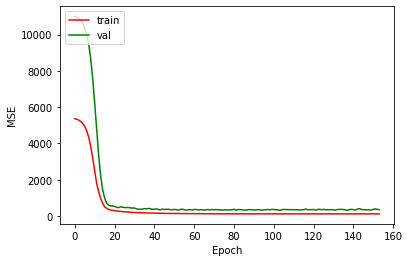

In [35]:
plt.plot(model_train.history['loss'], color='r', )
plt.plot(model_train.history['val_loss'], color='g')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_hz.png", dpi=200)


In [19]:
#uncer net
unet = np.sqrt(np.min(model_train.history['val_loss']))
unet**2, np.min(model_train.history['loss'])


(314.7200622558594, 119.19903564453125)

In [20]:
pred = neural_model.predict(z_test)
pred

array([[ 90.30488 ,  18.975204],
       [102.61611 ,  21.540968],
       [114.819786,  24.087637],
       [116.53077 ,  24.443478],
       [144.96436 ,  30.354254],
       [154.21231 ,  32.27649 ],
       [177.15836 ,  37.049217]], dtype=float32)

In [21]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [22]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = neural_model.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

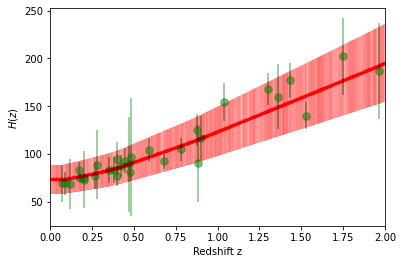

In [36]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
# plt.savefig("Overfitting_synthetic_HD.png")

In [24]:
# Cosmological constants
Om = 0.27
# variance network


In [25]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

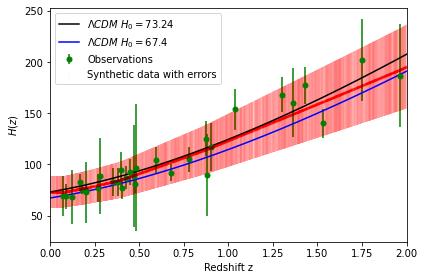

In [37]:
z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=67.4), label='$\Lambda CDM$ $H_0 = 67.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

plt.savefig("SyntheticHDrelu.png",dpi=800)

In [27]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [28]:
# randomselection = np.random.randint(0,1000,50)
randomselection = np.random.randint(0,1000,100)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [29]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


# np.savetxt("autoEncoderHz100.dat",mookHz, delimiter=" ")

In [30]:
predy_reduced[:,1]

array([28.348413, 23.637205, 31.934431, 18.475437, 26.922392, 20.788263,
       36.068275, 32.49303 , 34.576332, 37.029793, 15.377698, 30.305159,
       28.099457, 27.267817, 40.459984, 16.54183 , 24.68109 , 31.586292,
       24.340998, 20.28022 , 20.647348, 31.435802, 31.580675, 28.224386,
       26.238718, 20.655844, 23.417688, 27.129282, 32.12712 , 37.04203 ,
       25.77029 , 16.358347, 37.00096 , 25.368383, 15.387077, 16.35112 ,
       24.273561, 26.286068, 28.290525, 19.0606  , 15.848478, 24.029587,
       15.384718, 15.389366, 17.15854 , 27.003538, 16.000835, 26.103947,
       18.771503, 15.420841, 15.537949, 15.561562, 36.4038  , 20.805025,
       40.13315 , 18.771503, 17.783262, 29.044563, 26.2949  , 30.668968,
       25.910887, 26.103947, 25.050976, 37.0447  , 35.230125, 25.371393,
       18.099577, 18.233831, 29.78429 , 21.553083, 15.387077, 21.759892,
       18.489088, 36.366997, 33.061836, 15.939865, 34.70414 , 35.75778 ,
       40.450493, 38.997463, 33.43444 , 32.07448 , 

In [31]:
error  = predy_reduced[:,1]**2
error

array([ 803.63257,  558.71747, 1019.80786,  341.34177,  724.8152 ,
        432.1519 , 1300.9205 , 1055.797  , 1195.5227 , 1371.2056 ,
        236.47359,  918.40265,  789.57947,  743.5338 , 1637.0103 ,
        273.63214,  609.1562 ,  997.69385,  592.4842 ,  411.28732,
        426.313  ,  988.20966,  997.33905,  796.61597,  688.47034,
        426.66388,  548.3881 ,  735.9979 , 1032.1519 , 1372.112  ,
        664.10785,  267.59552, 1369.0712 ,  643.5549 ,  236.76215,
        267.35913,  589.2058 ,  690.9574 ,  800.3538 ,  363.3065 ,
        251.17427,  577.421  ,  236.68954,  236.8326 ,  294.41553,
        729.1911 ,  256.02673,  681.416  ,  352.36935,  237.80234,
        241.42784,  242.1622 , 1325.2367 ,  432.84906, 1610.6696 ,
        352.36935,  316.24442,  843.5867 ,  691.4218 ,  940.58563,
        671.374  ,  681.416  ,  627.5514 , 1372.3098 , 1241.1617 ,
        643.7076 ,  327.5947 ,  332.4726 ,  887.10394,  464.5354 ,
        236.76215,  473.4929 ,  341.84637, 1322.5585 , 1093.08

In [32]:
diagcov = np.diag(error) #inverso
# np.savetxt("autoEncoderHz_cov100.dat", diagcov, delimiter= " ", header="#100 100")
np.shape(diagcov)

(100, 100)

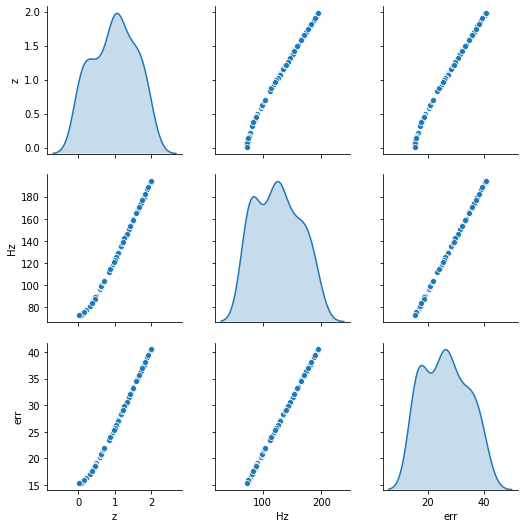

In [33]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("100hdmook.png")

In [34]:
4**4

256